In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

#####

import json
import bisect
import itertools

import ephem
import datetime

from operator import attrgetter

from tvgutil import contact_plan as cp, tvg

with open("../scenario.json", "r") as f:
    scenario = json.load(f)
with open("../ftvg.json", "r") as f:
    ftvg = tvg.from_serializable(json.load(f))
with open("../ptvg.json", "r") as f:
    ptvg = tvg.from_serializable(json.load(f))
    
fcp = tvg.to_contact_plan(ftvg)
pcp = tvg.to_contact_plan(ptvg)
      
gs_list = scenario["gslist"]
sat_list = scenario["satlist"]

print(f"Loaded scenario: {len(scenario['gslist'])} gs, {len(scenario['satlist'])} sat")
print(f"FCP has len = {len(fcp)}, PCP has len = {len(pcp)}")
print(f"F-TVG has {len(ftvg.vertices)} vertices and {len(ftvg.edges)} edges, P-TVG has {len(ptvg.vertices)} vertices and {len(ptvg.edges)} edges")
      
pcp_start_dict = {
    edge: [c.start_time for c in contacts]
    for edge, contacts in ptvg.edges.items()
}

def get_predicted_contact(tx, rx, start_time, end_time):
      
    cp = ptvg.edges[(tx, rx)]
    pcp_start = pcp_start_dict[(tx, rx)]

    def _overlap(pc):
        return end_time > pc.start_time and start_time < pc.end_time

    index = bisect.bisect_left(pcp_start, start_time)

    if index < len(cp) and _overlap(cp[index]):
        return cp[index]

    for i in itertools.count(1):
        if index - i < 0:
            break
        pc = cp[index - i]
        if _overlap(pc):
            return pc
        if pc.end_time < start_time:
            break

    for i in itertools.count(1):
        if index + i >= len(cp):
            break
        pc = cp[index + i]
        if _overlap(pc):
            return pc
        if pc.start_time > end_time:
            break

    return None

def gpc(fc):
    return get_predicted_contact(fc.tx_node, fc.rx_node, fc.start_time, fc.end_time)
      
fcp_start_dict = {
    edge: [c.start_time for c in contacts]
    for edge, contacts in ftvg.edges.items()
}

def get_factual_contact(tx, rx, start_time, end_time):
      
    cp = ftvg.edges[(tx, rx)]
    fcp_start = fcp_start_dict[(tx, rx)]

    def _overlap(fc):
        return end_time > fc.start_time and start_time < fc.end_time

    index = bisect.bisect_left(fcp_start, start_time)

    if index < len(cp) and _overlap(cp[index]):
        return cp[index]

    for i in itertools.count(1):
        if index - i < 0:
            break
        fc = cp[index - i]
        if _overlap(fc):
            return pc
        if fc.end_time < start_time:
            break

    for i in itertools.count(1):
        if index + i >= len(cp):
            break
        fc = cp[index + i]
        if _overlap(fc):
            return pc
        if fc.start_time > end_time:
            break

    return None

def gfc(pc):
    return get_factual_contact(pc.tx_node, pc.rx_node, pc.start_time, pc.end_time)
      
      
class SatelliteTrajectoryPredictor:

    def __init__(self, sat_name, tle_list, gs_lat, gs_lon, gs_alt):
        self.sgp4_inst = {
            int(start_time): self._init_sgp4(
                sat_name,
                tle,
                gs_lat,
                gs_lon,
                gs_alt,
            )
            for start_time, tle in tle_list
        }
        self.sgp4_inst_keys = list(sorted(self.sgp4_inst.keys()))

    def _init_sgp4(self, sat_name, tle, gs_lat, gs_lon, gs_alt):
        sat = ephem.readtle(str(sat_name), *tle)
        obs = ephem.Observer()
        obs.lat = str(gs_lat)  # pylint: disable=assigning-non-slot
        obs.lon = str(gs_lon)  # pylint: disable=assigning-non-slot
        obs.elevation = int(gs_alt)  # pylint: disable=assigning-non-slot

        def _sgp4(time):
            obs.date = datetime.datetime.utcfromtimestamp(time)
            sat.compute(obs)
            return sat.alt, sat.az

        return _sgp4

    def _get_sgp4(self, time):
        try:
            return self.sgp4_inst[self.sgp4_inst_keys[
                bisect.bisect_right(self.sgp4_inst_keys, time)
            ]]
        except IndexError:
            return self.sgp4_inst[self.sgp4_inst_keys[-1]]

    def predict_elevation(self, time):
        sgp4 = self._get_sgp4(time)
        alt, _ = sgp4(time)
        return alt

    def predict_azimuth(self, time):
        sgp4 = self._get_sgp4(time)
        _, az = sgp4(time)
        return az

trajectory_predictors = {
        frozenset((gs["id"], sat["id"])): SatelliteTrajectoryPredictor(
            sat["id"],
            sat["tle_list"],
            gs["lat"],
            gs["lon"],
            gs["alt"],
        )
        for gs, sat in itertools.product(gs_list, sat_list)
}

Loaded scenario: 2 gs, 3 sat
FCP has len = 214, PCP has len = 202
F-TVG has 5 vertices and 12 edges, P-TVG has 5 vertices and 12 edges


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


MSE w/ BER: 292181421105.58295 (34.0144 GiB²)


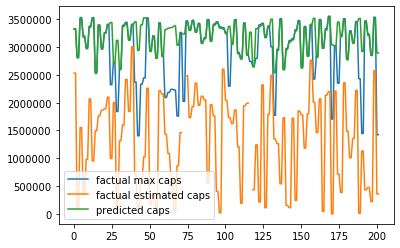

In [7]:
sfcp = [
    fc.to_simple(
        characteristics_at=fc.start_time
    )
    for fc in fcp
    if gpc(fc)
]
spcp = [
    gpc(fc).to_simple(
        generation_at=fc.start_time,
        characteristics_at=fc.start_time,
    )
    for fc in fcp
    if gpc(fc)
]

def hb(p):
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

fcaps = [
    (fc.end_time - fc.start_time) * fc.bit_rate
    for fc in sfcp
]
fcaps_real = [
    (fc.end_time - fc.start_time) * fc.bit_rate * hb(fc.bit_error_rate)
    for fc in sfcp
]
pcaps = [
    (pc.end_time - pc.start_time) * pc.bit_rate
    for pc in spcp
]

plt.plot(fcaps, label="factual max caps")
plt.plot(fcaps_real, label="factual estimated caps")
plt.plot(pcaps, label="predicted caps")

plt.legend()

a_pc = np.array(pcaps)
a_fc = np.array(fcaps)
a_fcr = np.array(fcaps_real)

mse = np.square(a_pc[np.isfinite(a_fc)] - a_fc[np.isfinite(a_fc)]).mean()

print(f"MSE w/ BER: {mse} ({round(mse / 8 / 1024 ** 3, 4)} GiB²)")

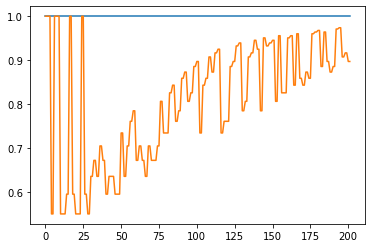

In [8]:
probspcp = [
    pc.to_simple(
        generation_at=pc.start_time,
        characteristics_at=pc.start_time,
    )
    for pc in pcp
]
probsfcp = [
    gfc(pc).to_simple(
        characteristics_at=gfc(pc).start_time,
    ) if gfc(pc) else None
    for pc in pcp
]
fc_happened = [gfc(pc) is not None for pc in pcp]

probs = [pc.probability for pc in probspcp]

plt.plot(fc_happened)
plt.plot(probs)

In [5]:
gen_starts = {
    gen.valid_from
    for pc in pcp
    for gen in pc.generations
}
len(sorted(gen_starts))

99